In [29]:
#imports
import kagglehub
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# Descarga del dataset de Urban Sound
path = kagglehub.dataset_download("rupakroy/urban-sound-8k")
print("Path to dataset files:", path)

100%|██████████| 5.61G/5.61G [10:32<00:00, 9.53MB/s]

Extracting files...


Path to dataset files: C:\Users\maria\.cache\kagglehub\datasets\rupakroy\urban-sound-8k\versions\1


# Preprocesamiento de Datos

In [ ]:
# Directorio de los audios
audio_dir = Path(path) / 'UrbanSound8K/audio'

# Cargar las etiquetas desde el archivo CSV
metadata = pd.read_csv(Path(path) / 'UrbanSound8K.csv')

# Crear un directorio para guardar los espectrogramas
output_dir = Path('UrbanSound_Spectrograms')
output_dir.mkdir(exist_ok=True, parents=True)

def generate_and_save_mel_spectrogram(audio_path, output_path, sr=22050, n_mels=128):
    # Cargar el archivo de audio
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Generar el espectrograma de Mel
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    
    # Convertir a escala logarítmica
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

    plt.figure(figsize=(2.56, 2.56))  # tamaño adecuado para que sea cuadrado 256x256 píxeles
    librosa.display.specshow(mel_spect_db, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')  # quita los ejes para que sea una imagen limpia
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Recorrer el archivo CSV para cada archivo de audio y generar el espectrograma
for index, row in metadata.iterrows():
    fold = row['fold']
    class_id = row['classID']
    file_name = row['slice_file_name']
    
    # Ruta del archivo de audio
    audio_path = audio_dir / f'fold{fold}' / file_name
    # Directorio de salida por clase
    class_dir = output_dir / str(class_id)
    class_dir.mkdir(exist_ok=True, parents=True)
    
    # Ruta de salida para el espectrograma
    output_path = class_dir / f"{file_name.replace('.wav', '.png')}"
    
    # Generar y guardar el espectrograma
    generate_and_save_mel_spectrogram(audio_path, output_path)
    print(f"Espectrograma guardado en: {output_path}")

Espectrograma guardado en: UrbanSound_Spectrograms\3\100032-3-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-117.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-121.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-126.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-137.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-143.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-161.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-3.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\100263-2-0-36.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\100648-1-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\100648-1-1-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\100648-1-2-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\100648-1-3-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\100648-1-4-0.png
Espectr

c:\Users\maria\miniconda3\envs\SoundClassifier\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


Espectrograma guardado en: UrbanSound_Spectrograms\1\17307-1-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-1.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-10.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-11.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-17.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-2.png
Espectrograma guardado en: UrbanSound_Spectrograms\9\173891-9-0-7.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173993-3-0-25.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173993-3-0-39.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173993-3-0-51.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173993-3-0-52.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173994-3-0-14.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173994-3-0-3.png
Espectrograma guardado en: UrbanSound_Spectrograms\3\173994-3-0-44.png
Espectrogram

c:\Users\maria\miniconda3\envs\SoundClassifier\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(


Espectrograma guardado en: UrbanSound_Spectrograms\1\87275-1-1-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\87275-1-2-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\87275-1-3-0.png


c:\Users\maria\miniconda3\envs\SoundClassifier\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Espectrograma guardado en: UrbanSound_Spectrograms\1\87275-1-4-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\1\87275-1-5-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\6\87562-6-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-0-1.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-0-2.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-0-3.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-1-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\8\88121-8-2-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\7\88466-7-0-0.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\88569-2-0-14.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\88569-2-0-21.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\88569-2-0-36.png
Espectrograma guardado en: UrbanSound_Spectrograms\2\88569-2-0-54.png
Espectrograma guardado en: Urb

# Entrenamiento del Modelo

Configuracion del dataset para entrenamiento de keras.

In [18]:
# Definimos el tamaño de las imágenes y el batch size
img_height, img_width = 128, 128
batch_size = 32

# Definimos el generador de datos para aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% para entrenamiento y 20% para validación
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'UrbanSound_Spectrograms',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'UrbanSound_Spectrograms',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 6988 images belonging to 10 classes.
Found 1744 images belonging to 10 classes.


Diseño de CNN

In [19]:
# Definimos el modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  # Regularización para reducir el overfitting
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout más alto en la capa densa final para regularizar aún más
    
    Dense(10, activation='softmax')  # 10 clases de sonidos urbanos
])

# Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostramos el resumen de la arquitectura del modelo
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo

In [21]:
# Número de épocas para entrenamiento
epochs = 20

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 692s 3s/step - accuracy: 0.1813 - loss: 2.1973 - val_accuracy: 0.2743 - val_loss: 1.9902
Epoch 2/20
  1/218 ━━━━━━━━━━━━━━━━━━━━ 5:28 2s/step - accuracy: 0.3125 - loss: 1.9125

c:\Users\maria\miniconda3\envs\SoundClassifier\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3125 - loss: 1.9125 - val_accuracy: 0.1875 - val_loss: 1.9860
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 690s 3s/step - accuracy: 0.2724 - loss: 1.9618 - val_accuracy: 0.2951 - val_loss: 1.9229
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4062 - loss: 1.7559 - val_accuracy: 0.3750 - val_loss: 1.6728
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.3614 - loss: 1.7833 - val_accuracy: 0.3779 - val_loss: 1.6795
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1875 - loss: 2.3274 - val_accuracy: 0.4375 - val_loss: 1.5438
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.4039 - loss: 1.6359 - val_accuracy: 0.4149 - val_loss: 1.5503
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3438 - loss: 1.6303 - val_accuracy: 0.3125 - val_loss: 1.6782
Epoch 9/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.4507 - loss: 1.5407 - val_accuracy: 0.4277 -

Evaluacion y resultados

In [22]:
# Evaluación del modelo en los datos de validación
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Accuracy en validación: {val_accuracy * 100:.2f}%")

55/55 ━━━━━━━━━━━━━━━━━━━━ 49s 896ms/step - accuracy: 0.5440 - loss: 1.2704
Accuracy en validación: 54.53%


# Visualizacion de los Resultados

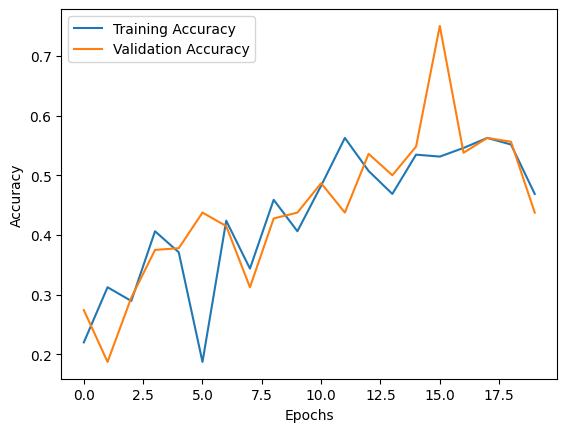

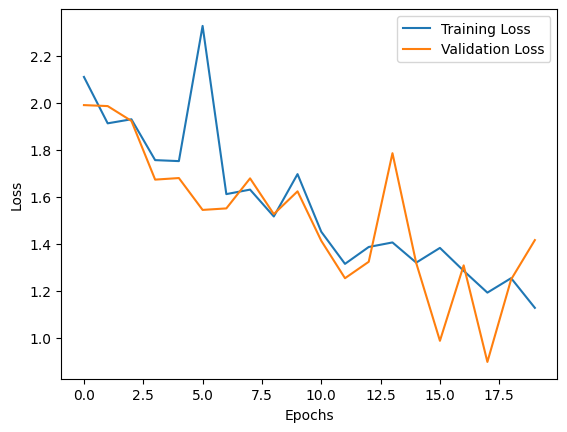

In [23]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ajustes al modelo

## Configuración del Dataset

In [24]:
# Definimos el tamaño de las imágenes y el batch size
img_height, img_width = 128, 128
batch_size = 32

# Definimos el generador de datos para aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,   # Se aumenta el rango de rotación
    width_shift_range=0.3,  # Se cambia el rango de desplazamiento horizontal
    height_shift_range=0.3,  # Se cambia el rango de desplazamiento vertical
    shear_range=0.3,    # Se aumenta más agresivo para el rango de cizallamiento
    zoom_range=0.3,     # Se aumenta más agresivo para el rango de zoom
    horizontal_flip=True,
    fill_mode='nearest'  # Se añade un modo de relleno para los píxeles faltantes
)


train_generator = train_datagen.flow_from_directory(
    'UrbanSound_Spectrograms',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'UrbanSound_Spectrograms',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 6988 images belonging to 10 classes.
Found 1744 images belonging to 10 classes.


## Diseño de CNN

In [35]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')
])

## Optimizacion con Adam

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Nuevo intento de Entrenamiento del Modelo

In [ ]:
# Número de épocas para entrenamiento
epochs = 20

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/20
 63/218 ━━━━━━━━━━━━━━━━━━━━ 9:47 4s/step - accuracy: 0.1481 - loss: 13.1324

## Evaluacion y Resultados

In [33]:
# Evaluación del modelo en los datos de validación
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Accuracy en validación: {val_accuracy * 100:.2f}%")

55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.3017 - loss: 3.7264
Accuracy en validación: 29.70%


## Visualización de los Resultados

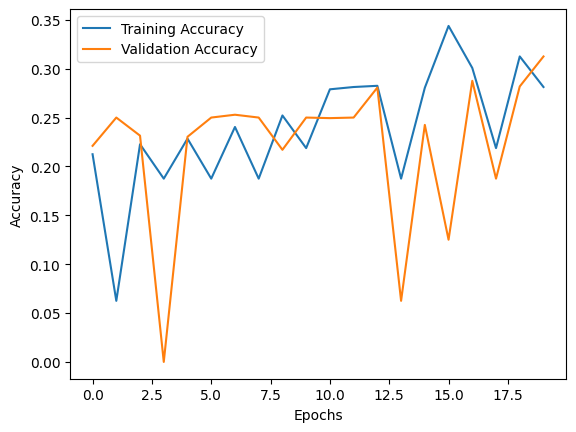

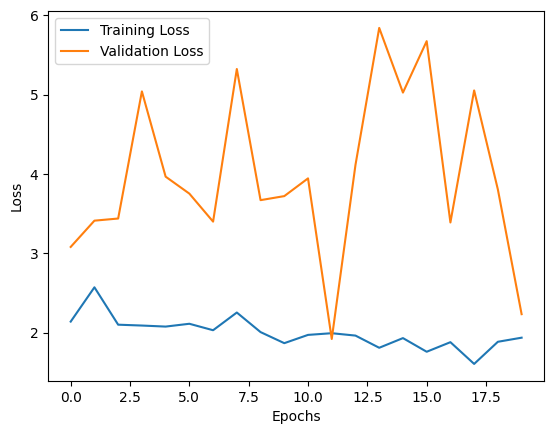

In [34]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()